# Notebook for exploring agentic package.

Exploring how each component works and what it outputs. Also, focuses on explore more for each suggestion. Search the internet, Hypothesize Impact, Forecast

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import glob

import sys

from dotenv import load_dotenv
load_dotenv()

_path = os.getcwd()
while "graphs" not in os.listdir(_path):

	_path = os.path.dirname(_path)

	if _path.replace("/", "").strip() == "":

		raise FileNotFoundError()
 
	if _path not in sys.path:

		sys.path.append(_path)

		print(f"Appending {_path} to path")

from graphs.answer_graph import build_answer_graph
from graphs.understand_graph import build_understand_graph  # if needed in later phases
from graphs.state import AgentState

import nest_asyncio
nest_asyncio.apply()

from utils.scraper import scrape_urls

from logger_config import setup_logger
logger = setup_logger()
logger.info("StratPilot started.")

from utils.sanitize import sanitize

Appending /mnt/d/Agentic Hackathon/agentic-app/workspace to path
Appending /mnt/d/Agentic Hackathon/agentic-app to path


2025-04-24 19:32:40,439 - stratpilot - INFO - StratPilot started.


In [2]:
#Prepare data (Read)

uploaded_files = glob.glob("/mnt/d/Agentic Hackathon/agentic-app/data/coffee-shop-sample-data/*")
datasets = {}
care = ["customer", "201904 sales reciepts", "product"]

for file in uploaded_files:
    if not any(c in file for c in care):
        continue

    df = pd.read_csv(file)
    dataset_label = os.path.basename(file).split(".")[0]

    inferred = {col: col for col in df.columns}
    column_descriptions = {}
    for col, guess in inferred.items():
        column_descriptions[col] = f"This column likely represents {guess}."

    datasets[sanitize(dataset_label)] = {
        "data": df,
        "description": dataset_label,
        "column_descriptions": column_descriptions
    }

## Let's explore each component

In [3]:
all_dataframes = {}
all_column_schemas = {}

for dataset_name, bundle in datasets.items():
    description = bundle.get("description", "").strip()
    df = bundle["data"]
    column_descriptions = bundle.get("column_descriptions", {})

    all_dataframes[dataset_name] = df
    all_column_schemas[dataset_name] = column_descriptions

business_profile = {
  'type': 'Cafe',
  'details': 'Independent neighborhood cafe located in a busy urban area, serving specialty coffee and light meals. Targets young professionals and students. Medium foot traffic, strong competition from chain coffee shops. Focused on in-store experience and Instagram-friendly ambiance. Operates 7 days a week with peak hours in the morning and late afternoon. Interested in increasing repeat customers and promoting seasonal items.'
}

In [4]:
#Explore dataset agentically
state = AgentState(
    business_profile=business_profile,
    datasets={},
    new_datasets=datasets,
    schema_context="",
    explored_datasets=[],
    memory_log=[]
)

In [5]:
understand_graph = build_understand_graph()
result = understand_graph.invoke(state)

state = AgentState(**result)
# user_question = state.suggested_questions[0]
# user_question = "How do sales vary by day of the week, and which days generate the highest revenue?"
# state.user_prompt = user_question
# state.data_sufficient = True

In [8]:
answer_graph = build_answer_graph()

final_state = answer_graph.invoke(state)

2025-04-17 12:19:51,806 - stratpilot - INFO - 🧠 [Planner] Planning...
2025-04-17 12:19:56,552 - stratpilot - INFO - 📤 [Planner Input]
System: You are a strategic data planner helping a business owner analyze their data in multiple steps. Your job is to break the problem into smart, executable steps based on their goal and data.

Each step must be:
- A complete, logical unit of analysis
- Executable in one code block
- Focused on moving the analysis forward (avoid tiny substeps)

Include:
- `step`: machine-friendly name
- `description`: instruction of what to do
- `goal`: the purpose of the step
- `expected_outputs`: names or types of output
- `assumptions`: expected data shape or availability
- `required_variables`: inputs from prior steps
- `outputs`: variables to produce for next steps
Human: 
Business Type: Cafe
Business Details: Independent neighborhood cafe located in a busy urban area, serving specialty coffee and light meals. Targets young professionals and students. Medium foot

TypeError: execute_python_code() takes 3 positional arguments but 4 were given

In [ ]:
final_state["insight_summary"]

'The analysis of sales by day of the week reveals a clear pattern where Monday stands out as the top revenue-generating day, significantly higher than other days. Wednesday and Tuesday also perform well, while Sunday consistently shows the lowest sales revenue. This pattern suggests that the cafe experiences stronger customer traffic and sales early in the week, possibly due to weekday routines of young professionals and students. Understanding these trends can help optimize staffing, promotions, and inventory management. Although no chart was generated, the summarized data table clearly ranks the days by total revenue, highlighting Monday as the peak day.'

## Test Search Tools for Case Study of that business

rewrite from business profile + insights -> tool search -> summarize

In [7]:
from llm.chains.search_chain import search_chain

result = search_chain.invoke({"business_profile": state.business_profile})

In [8]:
result

[{'url': 'https://www.forbes.com/sites/pauljankowski/2019/05/30/how-one-chicken-chain-is-winning-big-a-case-study-in-sticking-to-brand-values/',
  'title': 'How One Chicken Chain Is Winning Big: A Case Study In Sticking ...',
  'page_content': '  * Subscribe To Newsletters\n  * Trump Tracker\n  * Billionaires\n\nBillionaires\n\nView All Billionaires\n\n    * World\'s Billionaires\n    * Forbes 400\n    * America\'s Richest Self-Made Women\n    * China\'s Richest\n    * India\'s Richest\n    * Indonesia\'s Richest\n    * Korea\'s Richest\n    * Thailand\'s Richest\n    * Japan\'s Richest\n    * Australia\'s Richest\n    * Taiwan\'s Richest\n    * Singapore\'s Richest\n    * Philippines\' Richest\n    * Hong Kong\'s Richest\n    * Malaysia\'s Richest\n    * Money & Politics \n    * 2024 Election\n\n  * Innovation\n\nInnovation\n\nView All Innovation\n\n    * AI\n    * Big Data\n    * Cloud\n    * Cloud 100\n    * Consumer Tech\n    * Creator Economy\n    * Cybersecurity\n    * Digital Tr

In [9]:
#Next, need to extract insights from search results
#Parse in the business profile, page_content and title -> Ask to extract key actionable things done in the page to improve the business

from llm.chains.case_summary_chain import case_summary_chain
from tqdm import tqdm

summary_result = [case_summary_chain.invoke({"business_profile": state.business_profile, 
                                            "case_study_text": r["page_content"], 
                                            "case_study_title": r["title"]}) for r in tqdm(result)]

100%|██████████| 8/8 [01:12<00:00,  9.11s/it]


In [10]:
summary_result[5].model_dump()

{'thoughts': "This case study details the creation of 'The Secret Soirée', a curated marketplace connecting highly skilled chefs with high-net-worth individuals (HNIs) for intimate home gatherings. The study is comprehensive, outlining the market research, product strategy, channel strategy, monetization, and MVP features. I identified 8 actionable steps, each with a clear impact on business growth, customer experience, or operational efficiency. The focus is on solving the pain point of finding reliable, high-quality chefs for small upscale events, with a strong emphasis on curation, service, and technology-driven experience.",
 'business_profile': 'A digital marketplace platform (The Secret Soirée) that connects high-net-worth individuals (HNIs) in major Indian metro cities with pre-vetted, highly skilled chefs for intimate home gatherings and parties. The business differentiates itself through a curated chef network, end-to-end event management, and a focus on premium, personalized 

In [11]:
#Next, given the extacted insights from each case study, business insight, business profile, extracted business profile
#Check if any actions and impact is relevant to our business profile and the business insight
import random
idx = random.randint(0, len(summary_result)-1)
print(idx)
inputs = {"business_profile": state.business_profile,
          "insight": final_state["insight_summary"],
          "case_study_business_profile": summary_result[idx].business_profile,
          "actionables": summary_result[idx].actionables,
          "schema_context": state.schema_context}

from llm.chains.filter_actionable_chain import filter_actionable_chain
adapt_result = filter_actionable_chain.invoke(inputs)

2


NameError: name 'final_state' is not defined

In [ ]:
adapt_result.model_dump()

{'thought': "The target business is an independent neighborhood cafe serving specialty coffee and light meals, targeting young professionals and students, with a focus on in-store experience and increasing repeat customers. The case study business profile focuses on customer retention strategies through reallocating marketing budgets towards existing customers and implementing holistic retention programs. This aligns well with the target business's interest in increasing repeat customers and promoting seasonal items. Both businesses aim to deepen customer loyalty and improve customer lifetime value, making the case study relevant.",
 'relevant_case_study': True,
 'adapted_actionables': [{'thought': "Reallocating marketing budget to focus more on existing customers fits the cafe's goal to increase repeat customers. Given the insight that Monday is the top revenue day and Sunday the lowest, focusing retention efforts on existing loyal customers can stabilize and potentially increase sale

## Planning Question to gather insights

In [ ]:
from llm.chains.suggestor.question_generate_chain import question_generate_chain

user_request = "I want to increase customer during weekdays"

inputs = {"business_goal": user_request,
          "business_profile": state.business_profile,
          "schema_context": state.schema_context}

question_result = question_generate_chain.invoke(inputs)
question_result = question_result.model_dump()

## Modifying Answer Graph 

To make it suitable for both ML and vanilla data manipulation

In [13]:
import random

integrate_method = lambda x: f"Using {' and/or '.join(x['suggested_method'])} and emphasizing on these columns: {', '.join(x['related_fields'])}, {x['question']}"

q = random.choice(question_result['questions'])
q = question_result['questions'][1]
q = integrate_method(q)
print(q)

Using data manipulation and emphasizing on these columns: df_201904_sales_reciepts.transaction_date, df_201904_sales_reciepts.product_id, product.product_category, Which product categories or items are most frequently purchased during weekdays versus weekends?


In [14]:
from llm.chains.validate_data import validate_data_chain

# q = "How much is a cup of Americano in Starbucks?"
inputs = {"user_prompt": q,
          "schema_context": state.schema_context}

validate_result = validate_data_chain.invoke(inputs)
validate_result.model_dump()

{'thoughts': 'The user wants to compare the frequency of purchases for different product categories (and possibly individual items) between weekdays and weekends. The schema provides df_201904_sales_reciepts with transaction_date and product_id, and the product table with product_category. By joining df_201904_sales_reciepts on product_id to the product table, we can get the product_category for each transaction. We can use transaction_date to determine whether a transaction occurred on a weekday or weekend. Therefore, all necessary data is present to answer the question as posed.',
 'data_sufficient': True,
 'recommendations': ['Join df_201904_sales_reciepts with product on product_id to get product_category for each transaction.',
  'Convert transaction_date to a datetime object and derive the day of week to classify transactions as weekday or weekend.',
  'Aggregate counts of purchases by product_category (and optionally by product) for weekdays and weekends separately.',
  'Visuali

In [27]:
from llm.chains.suggestor.planner_chain import planner_chain

inputs = {"business_detail": state.business_profile,
          "schema_context": state.schema_context,
          "user_prompt": q}

planner_result = planner_chain.invoke(inputs)

In [28]:
planner_result

PlanOutput(steps=[PlanStep(step='step_1', description="Merge the sales receipts dataframe with the product dataframe on 'product_id' to bring product category information into the sales data. This will allow us to analyze sales at the product category level.", goal='Combine transactional sales data with product metadata to enable analysis by product category.', expected_outputs=['A merged dataframe with at least transaction_date, product_id, product_category columns'], assumptions=['Both dataframes have matching product_id values and no missing product_id entries'], required_variables=['df_201904_sales_reciepts', 'product'], required_libs=['pandas'], outputs=['sales_with_category']), PlanStep(step='step_2', description='Check for and handle missing values in key columns: transaction_date, product_id, product_category. Remove or impute missing values as appropriate to ensure clean analysis.', goal='Ensure data quality by addressing missing values that could bias the frequency analysis.'

## Test Suggestion Graph

In [6]:
from graphs.suggestion_graph import build_suggestor_graph
from graphs.state import AgentState

user_request = "I want to increase sales on weekdays"
state.user_prompt = user_request
state.variable_env = {}

2025-04-24 19:33:13,540 - stratpilot - INFO - [Question Generator Node Output]
['What are the sales volume and revenue trends for each weekday, and which weekdays currently have the lowest sales?', 'Which product categories and specific products have the highest sales and revenue on weekdays compared to weekends?', 'What is the repeat purchase rate of customers on weekdays, and which customer segments (e.g., by birth year or gender) show higher weekday visit frequency?', 'How effective have promotions been on weekdays in increasing sales volume and revenue, and which promotional items perform best during these days?', 'Which products are frequently purchased together on weekdays, especially during peak hours, that could be bundled or cross-promoted to increase average transaction value?']
2025-04-24 19:33:13,543 - stratpilot - INFO - [Selector] Selecting Question 0
2025-04-24 19:33:13,545 - stratpilot - INFO - [Selector] Available Questions: ['What are the sales volume and revenue tren

<Figure size 640x480 with 0 Axes>

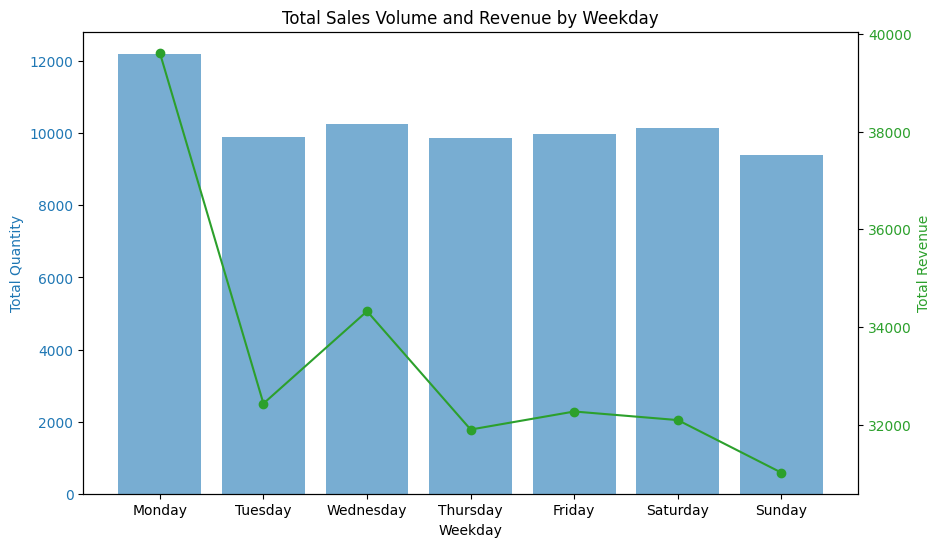

2025-04-24 19:33:56,318 - stratpilot - INFO - 📤 [Executor Output]
Aggregated sales volume and revenue by weekday (top 5 rows):
     weekday  total_quantity  total_revenue
0     Monday           12207       39614.34
1    Tuesday            9902       32430.36
2  Wednesday           10255       34320.73
3   Thursday            9875       31898.07
4     Friday            9978       32267.35
2025-04-24 19:33:56,321 - stratpilot - INFO - 📤 [Executor Error]
None
2025-04-24 19:33:56,322 - stratpilot - INFO - 📤 [Executor Chart Path]
None
2025-04-24 19:33:56,324 - stratpilot - INFO - [Executor] Current Index: 3, Plan Length: 5, Error: None
2025-04-24 19:33:56,327 - stratpilot - INFO - [Executor] Executing Step 3
2025-04-24 19:33:56,328 - stratpilot - INFO - [Executor] Plan: step_1: Convert the 'transaction_date' column in df_201904_sales_reciepts to datetime format and create a new column 'weekday' representing the day of the week (e.g., Monday, Tuesday).
step_2: Check for and handle any missin

<Figure size 640x480 with 0 Axes>

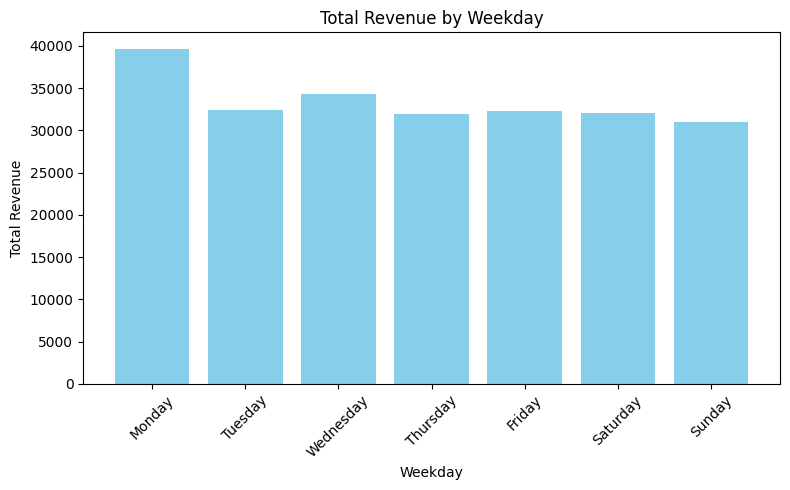

2025-04-24 19:35:13,668 - stratpilot - INFO - 📤 [Executor Output]
Weekday sales summary (top 5 rows):
     weekday  total_quantity  total_revenue
0     Monday           12207       39614.34
1    Tuesday            9902       32430.36
2  Wednesday           10255       34320.73
3   Thursday            9875       31898.07
4     Friday            9978       32267.35
2025-04-24 19:35:13,669 - stratpilot - INFO - 📤 [Executor Error]
None
2025-04-24 19:35:13,670 - stratpilot - INFO - 📤 [Executor Chart Path]
None
2025-04-24 19:35:13,671 - stratpilot - INFO - [Executor] Current Index: 3, Plan Length: 5, Error: None
2025-04-24 19:35:13,674 - stratpilot - INFO - [Executor] Executing Step 3
2025-04-24 19:35:13,676 - stratpilot - INFO - [Executor] Plan: step_1: Convert the 'transaction_date' column in df_201904_sales_reciepts to datetime format and create a new column 'weekday' representing the day of the week as a string (e.g., Monday, Tuesday).
step_2: Check for missing values in 'quantity' and '

<Figure size 640x480 with 0 Axes>

In [7]:
suggestor_graph = build_suggestor_graph()
result = suggestor_graph.invoke(state, {"recursion_limit": 100})

In [8]:
result["insights"]

[['Monday is the strongest sales day with 12,207 items sold and $39,614.34 revenue, indicating high customer traffic and demand.',
  'Tuesday to Friday have steady but lower sales volumes around 9,875 to 10,255 items and revenues between $31,898.07 and $34,320.73, suggesting consistent weekday performance.',
  'Sunday has the lowest sales volume (9,407 items) and revenue ($31,013.70), identifying it as the weakest sales day of the week.',
  'No missing data in quantity or line item amount ensures reliability of the sales trend analysis.',
  'The sales data can guide staffing and inventory planning to match peak demand on Mondays and optimize resources on Sundays.',
  'Promotional efforts could be focused on Sundays to increase foot traffic and sales on the lowest performing day.'],
 ['Weekdays have significantly higher total sales quantity and revenue for Bakery products compared to other categories, indicating strong weekday demand for these items.',
  'Top Bakery products on weekdays

In [9]:
result["strategies"]

[{'thought': 'Focusing promotional efforts on weekdays, especially targeting high-performing bakery products and leveraging the strong repeat purchase behavior among young female customers, will increase weekday sales. Insights show bakery items like Chocolate Croissant and Almond Croissant drive strong weekday revenue (Insight 02-02), promotions increase revenue per sale and repeat visits (Insights 04-01, 04-05), and younger female customers are frequent weekday visitors (Insights 03-02, 03-03, 03-04).',
  'supported_insights': ['Insight 02-02: Top Bakery products on weekdays include Chocolate Croissant (718 units, $2464.39), Almond Croissant (457 units, $1714.69), and Croissant (479 units, $1683.54), which are key revenue drivers.',
   'Insight 03-02: Female customers have a higher frequency of weekday visits compared to male and non-specified genders.',
   'Insight 03-03: Customers born in the 1990s exhibit higher weekday visit frequency.',
   'Insight 03-04: Repeat purchase behavio